In [1]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import glob
import json
from collections import defaultdict

import scipy
import scipy.cluster.hierarchy as hc

from sklearn.metrics import pairwise_distances

from cci_distance_correlation import get_correlation

%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

In [2]:
data_folder = '../data/'

In [3]:
import os

output_folder = '../results/CCI-GA-ICELLNET-LRs/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [4]:
files = dict()
files['rnaseq'] = data_folder + '/RNA-Seq/Celegans_RNASeqData_Cell.xlsx'
files['metadata'] = data_folder + '/RNA-Seq/Celegans_cell_metadata.tsv'
files['ppi'] = data_folder + '/PPI-Networks/Celegans-Curated-LR-pairs.xlsx'
files['phenotype'] = data_folder + '/Digital-3D-Map/Celegans_Physical_Distances_Min.csv'

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [5]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Metadata columns**

- <font color="green">'sample_col'</font> is the name of the column containing the sample or cell names in RNA-seq data (equivalent to the columns in rnaseq_data.
- <font color="green">'group_col'</font> is the name of the column containing the labels for the respective samples or cells in order to group/color them in downstream analyses.

In [6]:
meta_setup = dict()
meta_setup['sample_col'] = '#SampleID'
meta_setup['group_col'] = 'Groups'

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [7]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['Ligand_WB', 'Receptor_WB']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. 
    - 'constant_value'
    - 'local_percentile'
    - 'global_percentile'
    - None
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.75 represents the 75-th percentile, and the cutoff to binarize the gene expression will be that value.

In [8]:
cutoff_setup = dict()
cutoff_setup['type'] = 'constant_value'
cutoff_setup['parameter'] = 10 # TPM

**General Analysis setups**

- <font color="green">'communication_score'</font> is the type of communication score used to detect active pathways between each pair of cell. It can be:
    - 'expression_thresholding'
    - 'expression_product'
    - 'expression_correlation'
    - 'differential_combinations'
- <font color="green">'cci_score'</font> is the scoring function to aggregate the communication scores. It can be:
    - 'bray_curtis'
    - 'jaccard'
    - 'count'
- <font color="green">'cci_type'</font> is the type of interaction between two cells. If it is undirected, ligand and receptor are considered from both cells. If it is directed, ligands from one cell and receptors from the other are considered separately with respect to ligands from the second cell and receptor from the first one. So, it can be:
    - 'undirected'
    - 'directed

In [9]:
analysis_setup = dict()
analysis_setup['communication_score'] = 'expression_product'
analysis_setup['cci_score'] = 'icellnet'
analysis_setup['cci_type'] = 'undirected'

# Load Data

**RNA-seq**

In [10]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq datasets from ../data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx
../data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx was correctly loaded


In [11]:
rnaseq_data = rnaseq_data.applymap(lambda x: np.log2(x+1))

**Metadata for cell types**

In [12]:
meta = c2c.io.load_metadata(metadata_file=files['metadata'],
                            cell_labels=rnaseq_data.columns,
                            format='auto')

../data//RNA-Seq/Celegans_cell_metadata.tsv was correctly loaded


**PPI network**

In [13]:
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=list(rnaseq_data.index),
                           format='auto')

Opening PPI datasets from ../data//PPI-Networks/Celegans-Curated-LR-pairs.xlsx
../data//PPI-Networks/Celegans-Curated-LR-pairs.xlsx was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


In [14]:
ppi_data.shape

(245, 3)

In [15]:
symbol_lrs = pd.read_excel(files['ppi'])

In [16]:
symbol_lrs.head()

,Ligand_WB,Receptor_WB,Ligand_symbol,Receptor_symbol,LR Function,L Function,R Function,Ligand_desc_WormBase_versionWS277,Receptor_desc_WormBase_versionWS277,Pair_confidence,Location_type,Confidence_evidence,Location_evidence
0,WBGene00000182,WBGene00004040,arf-1.2,pld-1,Cell adhesion,ADP-ribosylation factor 1,Phospholipase D2,Is an ortholog of human ARF1 (ADP ribosylation...,Is an ortholog of human PLD2 (phospholipase D2...,Putative based on data,Membrane-bound,"Orthology, protein-protein interaction (STRING...",wormbase: arf-1 found in the endoplasmic retic...
1,WBGene00000903,WBGene00004860,daf-7,sma-6,TGF-B signaling,GDF11,BMPRIB,Is an ortholog of human GDF11 (growth differen...,Is an ortholog of human BMPR1A (bone morphogen...,Putative based on literature,Secreted,"Orthology, protein-protein interaction (STRING...","wormbase; "" Located in extracellular space,"" h..."
2,WBGene00005647,WBGene00008779,srp-6,F14B4.1,Wnt signaling,Serpin family (Blocks wnt signaling),Wnt-Receptor,Is an ortholog of human SERPINB10 (serpin fami...,Is predicted to have Wnt-activated receptor ac...,Putative based on literature,Secreted,"Orthology, protein-protein interaction (STRING...",wormbase: srp-6 is found and active in the ext...
3,WBGene00000074,WBGene00003930,adm-2,pat-3,Cell adhesion,ADAM,Integrin,Is an ortholog of several human genes includin...,Is an ortholog of human ITGB1 (integrin subuni...,Putative based on data,Membrane-bound,"Orthology, protein-protein interaction (STRING...",wormbase: adm-2 is an integral component of th...
4,WBGene00000074,WBGene00003929,adm-2,pat-2,Cell adhesion,ADAM,Integrin,Is an ortholog of several human genes includin...,Is an ortholog of human ITGA5 (integrin subuni...,Putative based on data,Membrane-bound,"Orthology, protein-protein interaction (STRING...",wormbase: adm-2 is an integral component of th...


In [17]:
tmp = ppi_data.copy()
tmp.columns = ['Ligand_WB', 'Receptor_WB', 'score']
symbol_lrs = tmp.merge(symbol_lrs, how='inner').drop_duplicates().reset_index()

**Phenotype**

In [18]:
physical_distance = pd.read_csv(files['phenotype'], index_col=0)

# Analysis

### Cells to include

In [19]:
included_cells = sorted(list(set(rnaseq_data.columns) & set(physical_distance.columns)))

In [20]:
excluded_cells = sorted(list(set(rnaseq_data.columns) - set(included_cells)))

In [21]:
excluded_cells

['Distal_tip_cells',
 'Sex_myoblasts',
 'Socket_cells',
 'Vulval_precursors',
 'flp-1(+)_interneurons']

### Collect & Preprocess GA Results

In [22]:
all_files = sorted(glob.glob(data_folder + "/GA-ICELLNET/*.json"))

selected_ppis = []
score_per_run = defaultdict(list)

max_corr = 0.0
max_array = []
for filename in all_files:
    print(filename)
    with open(filename) as json_file:
        data = json.load(json_file)
        runs = sorted([int(r.lstrip('run')) for r in data.keys()])
        selected_ppis.append(data['run{}'.format(runs[-1])]['ppi_data'])
        for r in runs:
            corr = data['run{}'.format(r)]['obj_fn']
            score_per_run[r].append(corr)
            if corr > max_corr:
                max_corr = corr
                max_array = data['run{}'.format(r)]['ppi_data']
            
#results['run{}'.format(runs_)] = {'obj_fn' : opt_score,
#                                          'ppi_data' : tmp_ppi['score'].values.tolist(),
#                                          'drop_fraction' : drop_fraction
#                                         }

../data//GA-ICELLNET/0141aa97-893c-4d25-9d69-5a1cde3c36b6.json
../data//GA-ICELLNET/043c0c44-cb36-4933-aa45-9ba70e004137.json
../data//GA-ICELLNET/04eeaf98-7f8d-4b90-afcc-a4f9f2294777.json
../data//GA-ICELLNET/07ec168f-f388-4b7e-a49a-604786ee3f3c.json
../data//GA-ICELLNET/09b258c9-fdfc-494e-b9e5-64db43d0fe1b.json
../data//GA-ICELLNET/0cfdcee9-0f8e-4358-9c3a-0a796ed09399.json
../data//GA-ICELLNET/0e6b3adc-9f2b-4dcd-a22e-6674784b5c72.json
../data//GA-ICELLNET/0ede2cc0-45d3-4766-8a45-7d54a3e59f71.json
../data//GA-ICELLNET/100ca935-c1eb-4b07-a726-84a0c19291d4.json
../data//GA-ICELLNET/125c57d5-52e8-47e9-aea0-b5b2682cc551.json
../data//GA-ICELLNET/189658b0-cf4d-4192-ad93-99c4ca5d551c.json
../data//GA-ICELLNET/1a21bc2b-5e9c-4c4b-b482-01cef524b8e2.json
../data//GA-ICELLNET/1b3a7d48-b2b6-4da1-bbd3-cf2658b7129a.json
../data//GA-ICELLNET/1b60b00f-fe09-4777-95be-70f4d42281a2.json
../data//GA-ICELLNET/1c428010-feb4-499d-8fce-4ec6e5dea6cb.json
../data//GA-ICELLNET/1f6be7f3-70ae-4f47-b4fa-409f79b3eb

In [23]:
with open(filename) as json_file:
    data = json.load(json_file)

**Ratio of selection for each LR pair**

In [24]:
ratio_selected_ppis = np.nansum(np.array(selected_ppis), axis=0) / len(selected_ppis)

In [25]:
ga_selected_ppi_data = ppi_data.copy()
ga_selected_ppi_data['score'] = ratio_selected_ppis

**LR pairs selected in the list that led to maximal correlation**

In [26]:
max_ga_selected = ppi_data.copy()
max_ga_selected['score'] = np.array(max_array).astype(int)

# Plot results

### Correlations

**Correlation for basal PPI list**

In [27]:
ref_distance_vector = scipy.spatial.distance.squareform(physical_distance.loc[included_cells, included_cells].values)

bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=ppi_data, verbose=False)

interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                              ppi_data=bi_ppi_data,
                                              gene_cutoffs=cutoff_setup,
                                              communication_score=analysis_setup['communication_score'],
                                              cci_score=analysis_setup['cci_score'],
                                              cci_type=analysis_setup['cci_type'],
                                              verbose=False)

# Compute interactions
interaction_space.compute_pairwise_cci_scores(use_ppi_score=True, verbose=False)

# Distance matrix from analysis
result_matrix = interaction_space.distance_matrix.loc[included_cells, included_cells]

# Compute correlations
result_distance_vector = scipy.spatial.distance.squareform(result_matrix)
corr = scipy.stats.spearmanr(result_distance_vector, ref_distance_vector)
base_result = abs(np.nan_to_num(corr[0]))

**Structure data for visualization**

In [28]:
mean_values = [base_result]
std_values = [0.0]

for k in sorted(list(score_per_run.keys())):
    v = score_per_run[k]
    mean_values.append(np.nanmean(v))
    std_values.append(np.nanstd(v))
    
run_values = list(range(len(mean_values)))

data = np.array(list(zip(run_values, mean_values, std_values)))
df = pd.DataFrame(data, columns=['X', 'MEAN', 'STD'])

**Plot results**

In [29]:
max_corr

0.7054949986833712

In [30]:
mean_values

[0.30456263973340303,
 0.557485595263601,
 0.6564809996695611,
 0.6662653265569273,
 0.6821437882908472]

In [31]:
std_values

[0.0,
 0.005706146469299825,
 0.00894543945249132,
 0.011730612226509077,
 0.009518013739417266]

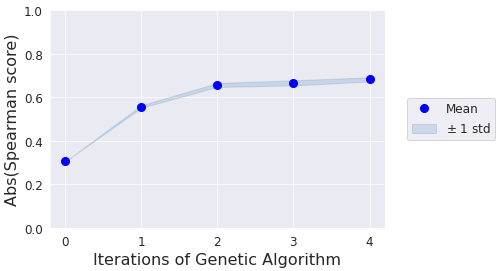

In [32]:
with sns.axes_style("darkgrid"):
    fig=plt.plot('X', 'MEAN', data=df, linestyle='', marker='o', markersize=8, color='b', label='Mean')
    
    mean_precision = np.array(mean_values)
    std_precision = np.array(std_values)
    precision_upper = np.minimum(mean_precision + std_precision, 1)
    precision_lower = np.maximum(mean_precision - std_precision, 0)

    plt.fill_between(run_values, precision_lower, precision_upper, color='steelblue', alpha=.2, 
                     label='$\pm$ 1 std')
        
    plt.xticks(run_values)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(0,1)
    
    plt.xlabel('Iterations of Genetic Algorithm', fontsize=16)
    plt.ylabel('Abs(Spearman score)', fontsize=16)
    
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fancybox=True, shadow=False, fontsize=12)
    
    plt.savefig(output_folder + '/GA3-Runs.svg',
                dpi=300,
                bbox_inches='tight')

### Distributions of PPIs

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


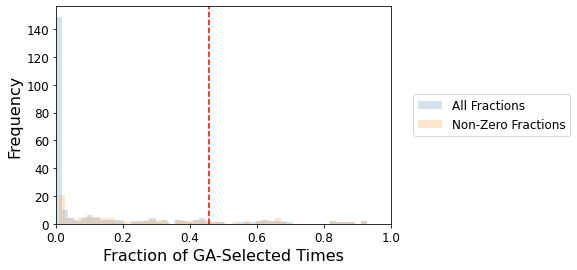

In [33]:
threshold = np.percentile(ga_selected_ppi_data['score'], 90)

ax = sns.distplot(ga_selected_ppi_data['score'],
                  bins=50,
                  kde=False,
                  label='All Fractions',
                  hist_kws={'alpha' : 0.2})

ax = sns.distplot(ga_selected_ppi_data.loc[ga_selected_ppi_data['score'].values > 0.]['score'],
                  bins=50,
                  kde=False,
                  ax=ax,
                  label='Non-Zero Fractions',
                  hist_kws={'alpha' : 0.2})

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fancybox=True, shadow=False, fontsize=12)

plt.axvline(x=threshold, c='r', ls='--')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0,1)

plt.xlabel('Fraction of GA-Selected Times', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.savefig(output_folder + '/GA3-Distribution.svg',
                dpi=300,
                bbox_inches='tight')

In [34]:
threshold

0.45599999999999996

### Conserved LR pairs

In [35]:
from sklearn.metrics import pairwise_distances

In [36]:
lrs = symbol_lrs.apply(lambda row: row['Ligand_symbol'] + '_' + row['Receptor_symbol'], axis=1)
lrs2 = symbol_lrs.apply(lambda row: row['Ligand_symbol'] + ' / ' + row['Receptor_symbol'], axis=1)

In [37]:
lr_dict = pd.DataFrame()
lr_dict['symbol'] = symbol_lrs.apply(lambda row: row['Ligand_symbol'] + '_' + row['Receptor_symbol'], axis=1)
lr_dict['WB'] = symbol_lrs.apply(lambda row: row['Ligand_WB'] + '_' + row['Receptor_WB'], axis=1)
lr_dict.set_index('symbol', inplace=True)

**Presence**

In [38]:
df = pd.DataFrame(np.array(selected_ppis), columns=lrs).astype(int)

In [39]:
df.head()

,arf-1.2_pld-1,daf-7_sma-6,srp-6_F14B4.1,adm-2_pat-3,adm-2_pat-2,let-756_sdn-1,let-756_ver-3,let-756_ver-1,srp-2_F14B4.1,srp-1_try-1,...,emb-9_ddr-2,mec-1_mec-4,mec-5_mec-4,mec-9_mec-4,mec-1_mec-10,mec-5_mec-10,mec-9_mec-10,shn-1_ced-1,col-119_daf-4,col-19_daf-4
0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,1,0,1,0
1,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,1,1,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,1,1,0,1,1
3,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,1,1,1,0,1,1
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,1,0,1,1


/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


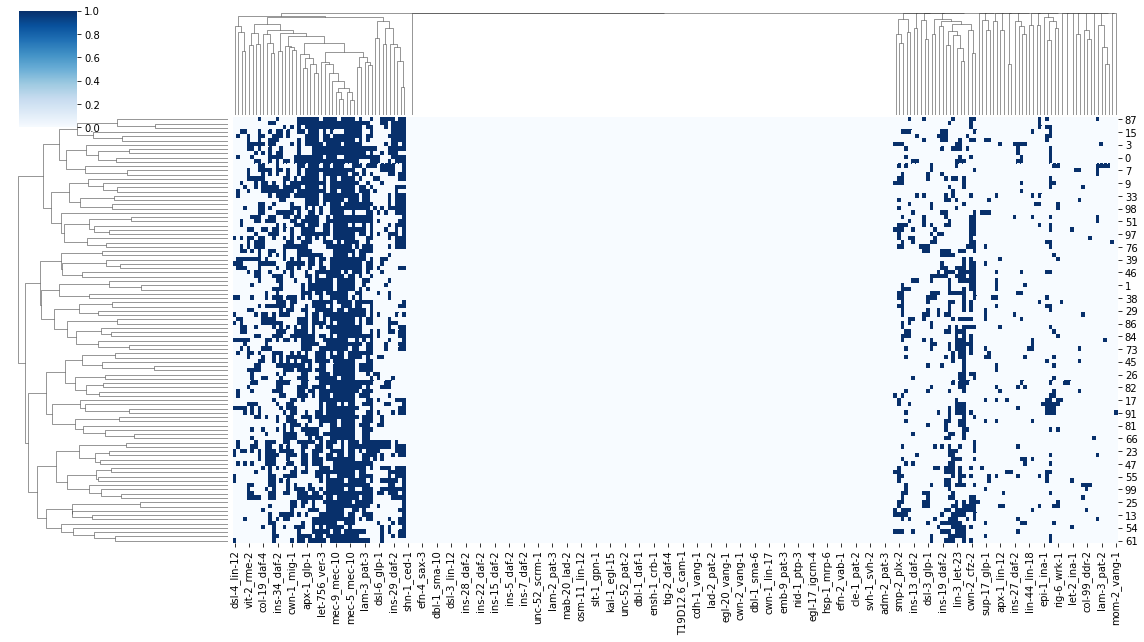

In [40]:
sns.clustermap(df,
               metric='jaccard',
               method='complete',
               col_cluster=True,
               row_cluster=True,
               cmap='Blues',
               figsize=(16, 9)
              )
plt.savefig(output_folder + '/GA3-LRs-Runs.svg',
                dpi=300,
                bbox_inches='tight')

**Co-occurrence**

In [41]:
co = pd.DataFrame(np.zeros((len(lrs), len(lrs))), columns=lrs, index=lrs)
for i, lr in enumerate(lrs):
    v1 = df[lr]
    for j, lr2 in enumerate(lrs[i:]):
        v2 = df[lr2]
        if sum(v1.values | v2.values) == 0:
            val = 0.0
        else:
            val = sum(v1.values & v2.values) / sum(v1.values | v2.values)
        
        co.at[lr, lr2] = val
        co.at[lr2, lr] = val

In [42]:
co.head()

,arf-1.2_pld-1,daf-7_sma-6,srp-6_F14B4.1,adm-2_pat-3,adm-2_pat-2,let-756_sdn-1,let-756_ver-3,let-756_ver-1,srp-2_F14B4.1,srp-1_try-1,...,emb-9_ddr-2,mec-1_mec-4,mec-5_mec-4,mec-9_mec-4,mec-1_mec-10,mec-5_mec-10,mec-9_mec-10,shn-1_ced-1,col-119_daf-4,col-19_daf-4
arf-1.2_pld-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
daf-7_sma-6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.011494,0.0,0.0,...,0.0,0.0,0.0,0.0,0.030303,0.011236,0.0,0.0,0.010753,0.034483
srp-6_F14B4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
adm-2_pat-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
adm-2_pat-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [43]:
col_bins = 10
data = co.loc[(co != 0).any(), (co != 0).T.any()]
colors = ga_selected_ppi_data['score']
colors.index = ga_selected_ppi_data.apply(lambda row: row['A'] + '_' + row['B'], axis=1)
colors = colors.loc[lr_dict.loc[co.columns, 'WB']]
colors.index = co.columns
colors_df = colors.copy()
colors_df.index = lrs2
colors = colors.apply(lambda x: plt.get_cmap("YlOrRd",col_bins)(x))
colors.name = 'Presence in Optimal Lists'

In [44]:
colors_df.to_frame().to_csv(output_folder + '/Celegans-GA-ICELLNET-Run-Ratios.csv')

In [45]:
colors_df.sort_values(ascending=False)

col-119 / daf-4    0.93
lin-44 / mig-1     0.92
mec-5 / mec-10     0.89
let-756 / ver-1    0.87
mec-9 / mec-10     0.85
                   ... 
tig-2 / daf-4      0.00
sfrp-1 / lin-18    0.00
tig-3 / sma-6      0.00
tig-2 / sma-6      0.00
unc-52 / pat-2     0.00
Name: score, Length: 245, dtype: float64

In [46]:
colors_export = colors.to_frame()
colors_export.columns = ['Color']
colors_export.index = colors_df.index

In [47]:
colors_export.to_csv(output_folder + '/Celegans-GA-ICELLNET-Run-Ratios-Color.csv')

In [48]:
data.shape

(110, 110)

In [49]:
c_input = data
D = pairwise_distances(c_input)
linkage = hc.linkage(D, method='ward', optimal_ordering=True)

In [50]:
D.shape

(110, 110)

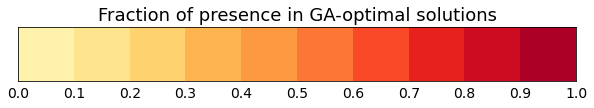

In [51]:
sns.palplot(sns.color_palette("YlOrRd", col_bins))
for i, text in enumerate(sns.color_palette("YlOrRd", col_bins + 1)):
    plt.text(i-0.5, 0.6, i/col_bins, rotation=0, horizontalalignment='center', verticalalignment='top',fontsize=14)
plt.title('Fraction of presence in GA-optimal solutions', fontsize=18)
plt.tick_params(axis='both', which='major', bottom=False, left=False,labelsize=16)
plt.savefig(output_folder + '/GA-ICELLNET-Fraction-Colors.svg',
                dpi=300,
                bbox_inches='tight')

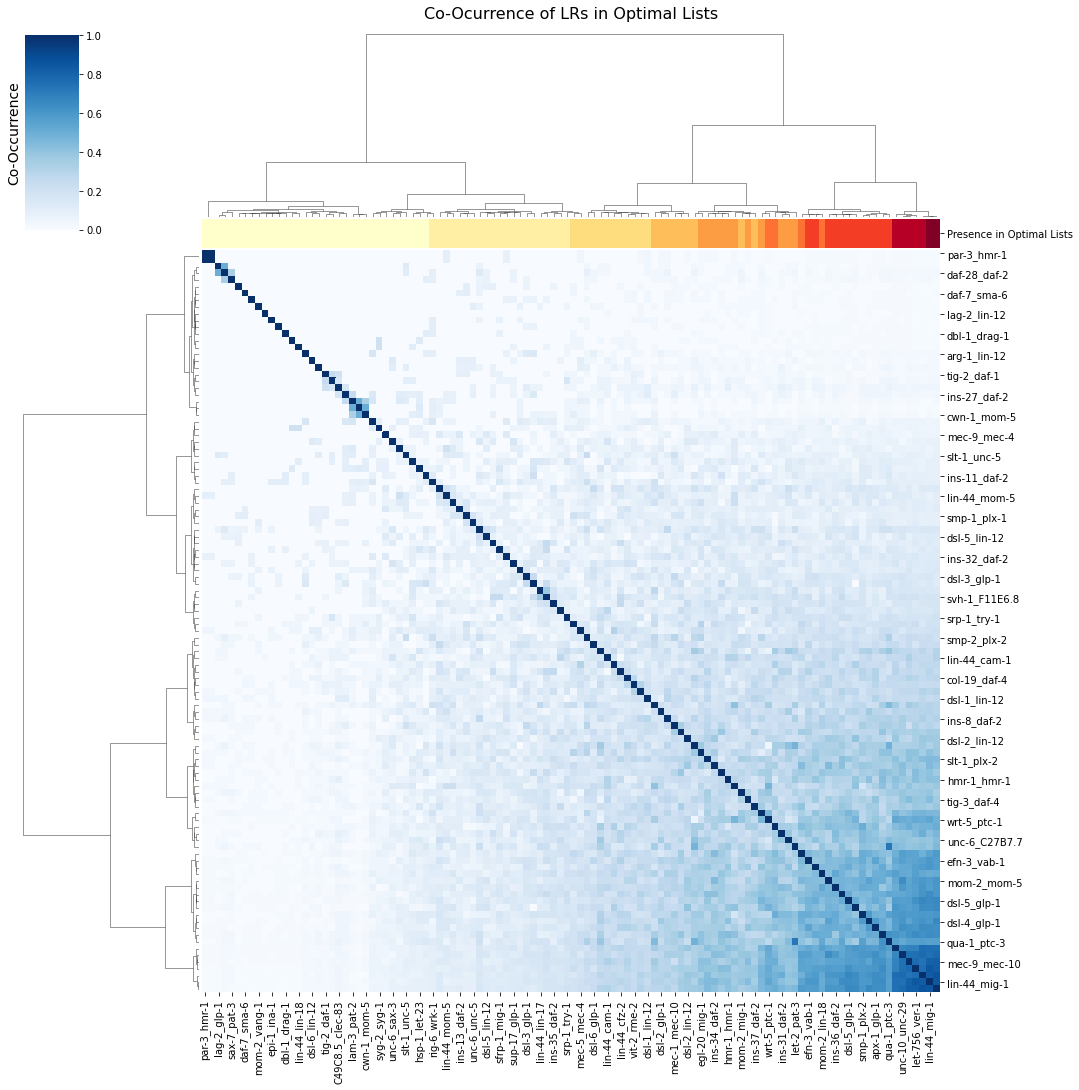

In [52]:
co_clusters = sns.clustermap(c_input,
                             method='ward',
                             cmap='Blues',
                             col_linkage=linkage,
                             row_linkage=linkage,
                             figsize=(15, 15),
                             col_colors=colors
                             )
# Title
co_clusters.ax_col_dendrogram.set_title('Co-Ocurrence of LRs in Optimal Lists', fontsize=16)

# Color bar label
cbar = co_clusters.ax_heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Co-Occurrence', fontsize=14)
cbar.ax.yaxis.set_label_position("left")

plt.savefig(output_folder + '/GA-ICELLNET-Co-Ocurrence.svg',
                dpi=300,
                bbox_inches='tight')

In [53]:
clusters = c2c.clustering.get_clusters_from_linkage(co_clusters.dendrogram_col.linkage, 2)

# Export Selected LRs

**Selected by Co-occurrence**

In [54]:
records = []
selected_cluster = np.argmin([len(c) for c in clusters.values()]) + 1

for idx, row in lr_dict.loc[co_clusters.data.index[clusters[selected_cluster]]].iterrows():
    records.append((*row['WB'].split('_'), *idx.split('_')))
    
ga_export = pd.DataFrame.from_records(records, 
                                      columns=['Ligand_WB', 'Receptor_WB', 'Ligand_symbol', 'Receptor_symbol'])

ga_export = ga_export.assign(score=1.0)
ga_export = ga_export.merge(symbol_lrs, how='inner')

In [55]:
ga_export

,Ligand_WB,Receptor_WB,Ligand_symbol,Receptor_symbol,score,index,LR Function,L Function,R Function,Ligand_desc_WormBase_versionWS277,Receptor_desc_WormBase_versionWS277,Pair_confidence,Location_type,Confidence_evidence,Location_evidence
0,WBGene00002881,WBGene00006896,let-756,ver-3,1.0,6,Canonical RTK-Ras-ERK signaling,FGF,Tyrosine-protein kinase (GF-Receptor),Is an ortholog of human FGF16 (fibroblast grow...,Is an ortholog of human FLT1 (fms related rece...,Putative based on literature,Secreted,"Orthology, protein-protein interaction (STRING...",wormbase: let-756 is found in the cytoplasm;ex...
1,WBGene00002881,WBGene00006894,let-756,ver-1,1.0,7,Canonical RTK-Ras-ERK signaling,FGF,fms-related tyrosine kinase 1,Is an ortholog of human FGF16 (fibroblast grow...,Is an ortholog of human FLT1 (fms related rece...,Putative based on literature,Secreted,"Orthology, protein-protein interaction (STRING...",wormbase: let-756 is found in the cytoplasm;ex...
2,WBGene00003029,WBGene00003238,lin-44,mig-1,1.0,25,Wnt signaling,Wnt,Frizzled,Is an ortholog of human WNT10A (Wnt family mem...,Is predicted to have Wnt-activated receptor ac...,Literature supported,Secreted,"WormBook, DOIs: 10.1016/j.devcel.2006.02.010; ...",wormbase: lin-44 is said to be located in the ...
3,WBGene00002280,WBGene00003930,let-2,pat-3,1.0,26,Cell adhesion,Collagen,Integrin,Is an ortholog of human COL4A5 (collagen type ...,Is an ortholog of human ITGB1 (integrin subuni...,Literature supported,ECM-component,10.1083/jcb.201903124,Wormbase: let-2 is located in the extracellula...
4,WBGene00001164,WBGene00006868,efn-3,vab-1,1.0,27,Eph receptor signaling,Ephrin,EphR,Is an ortholog of human EFNB1 (ephrin B1); EFN...,Is an ortholog of human EPHA1 (EPH receptor A1...,Literature supported,Membrane-bound,WormBook,wormbase: efn-3 is located in the plasma membr...
5,WBGene00000674,WBGene00016104,col-99,ddr-1,1.0,35,Cell adhesion,Collagen,Discoidin domain receptor,Is an ortholog of human COL13A1 (collagen type...,Is an ortholog of human DDR1 (discoidin domain...,Literature supported,ECM-component,DOI: 10.1016/j.mcn.2018.03.003,wormbase: col-99 is located in the extracellul...
6,WBGene00003395,WBGene00003397,mom-2,mom-5,1.0,38,Wnt signaling,Wnt,Frizzled,Exhibits receptor tyrosine kinase binding acti...,Is an ortholog of human FZD1 (frizzled class r...,Literature supported,Secreted,"WormBook, DOIs: 10.1016/j.devcel.2006.02.010; ...",https://www.ncbi.nlm.nih.gov/gene?Db=gene&Cmd=...
7,WBGene00006746,WBGene00007764,unc-6,C27B7.7,1.0,44,Cell migration,Netrin (dorsal-ventral),Ig domain - Receptor,Is an ortholog of human NTN1 (netrin 1). Is pr...,Is an ortholog of human DSCAM (DS cell adhesio...,Putative based on literature,Secreted,"Orthology, protein-protein interaction (STRING...",wormbase: unc-6 is found to be located in axon...
8,WBGene00001700,WBGene00004208,grd-11,ptc-1,1.0,50,Hedgehog signaling,DHH,PTCH1,Is an ortholog of human DHH (desert hedgehog s...,Is an ortholog of human PTCH1 (patched 1) and ...,Literature supported,Membrane-bound,DOIs: 10.1186/1471-2164-7-280; 10.1016/j.ydbio...,wormbase: ptc-1 is a receptor that is membrane...
9,WBGene00000857,WBGene00003238,cwn-1,mig-1,1.0,60,Wnt signaling,Wnt,Frizzled,Is an ortholog of human WNT4 (Wnt family membe...,Is predicted to have Wnt-activated receptor ac...,Literature supported,Secreted,"WormBook, DOIs: 10.1016/j.devcel.2006.02.010; ...",wormbase: annotated as found in the extracellu...


In [56]:
ga_export.shape

(53, 15)

In [57]:
ga_export.to_csv(data_folder + '/PPI-Networks/Celegans-GA-ICELLNET-Selected-LR-pairs.csv', index=False)
ga_export.to_csv(output_folder + '/Celegans-GA-ICELLNET-Selected-LR-pairs.csv', index=False)

# Analyze functions in lists selected across all GA runs

**Generate function metadata**

In [58]:
functions = symbol_lrs['LR Function'].unique()

In [59]:
function_colors = c2c.plotting.get_colors_from_labels(functions, cmap='tab20')

In [60]:
func_color_dict = dict()
row_cols = []
row_functions = []
for idx, row in symbol_lrs.iterrows():
    name = str(row['Ligand_symbol']) + '_' + str(row['Receptor_symbol'])
    func = str(row['LR Function'])
    func_color_dict[name] = function_colors[func]
    row_cols.append((name, function_colors[func]))
    row_functions.append((name, func))
row_cols = pd.DataFrame.from_records(row_cols, columns=['LR', 'Function']).set_index('LR')
row_functions = pd.DataFrame.from_records(row_functions, columns=['LR', 'Function']).set_index('LR')

In [61]:
func_mapper = row_functions.to_dict()['Function']

**Compute fraction of each function in each GA-selected list**

In [62]:
func_count = df.T
func_count.index = df.columns.map(func_mapper)

In [63]:
func_count = func_count.reset_index().groupby('index').sum()

In [64]:
func_frac = func_count / func_count.sum()

In [65]:
sorted_order = func_frac.T.median().sort_values(ascending=False).index

In [66]:
sorted_order

Index(['Wnt signaling', 'Cell migration', 'Notch signaling', 'Cell adhesion',
       'Insulin signaling', 'Mechanosensory mechanism',
       'Canonical RTK-Ras-ERK signaling', 'Hedgehog signaling',
       'TGF-B signaling', 'Neuronal communication', 'Eph receptor signaling',
       'Receptor-Mediated-Endocytosis', 'Trypsin-like proteolysis',
       'Stress response', 'Apoptosis', 'PCP pathway', 'Lipid homeostasis',
       'Immune response', 'Epidermal development', 'Longevity'],
      dtype='object', name='index')

**Plot Fraction for each Function**

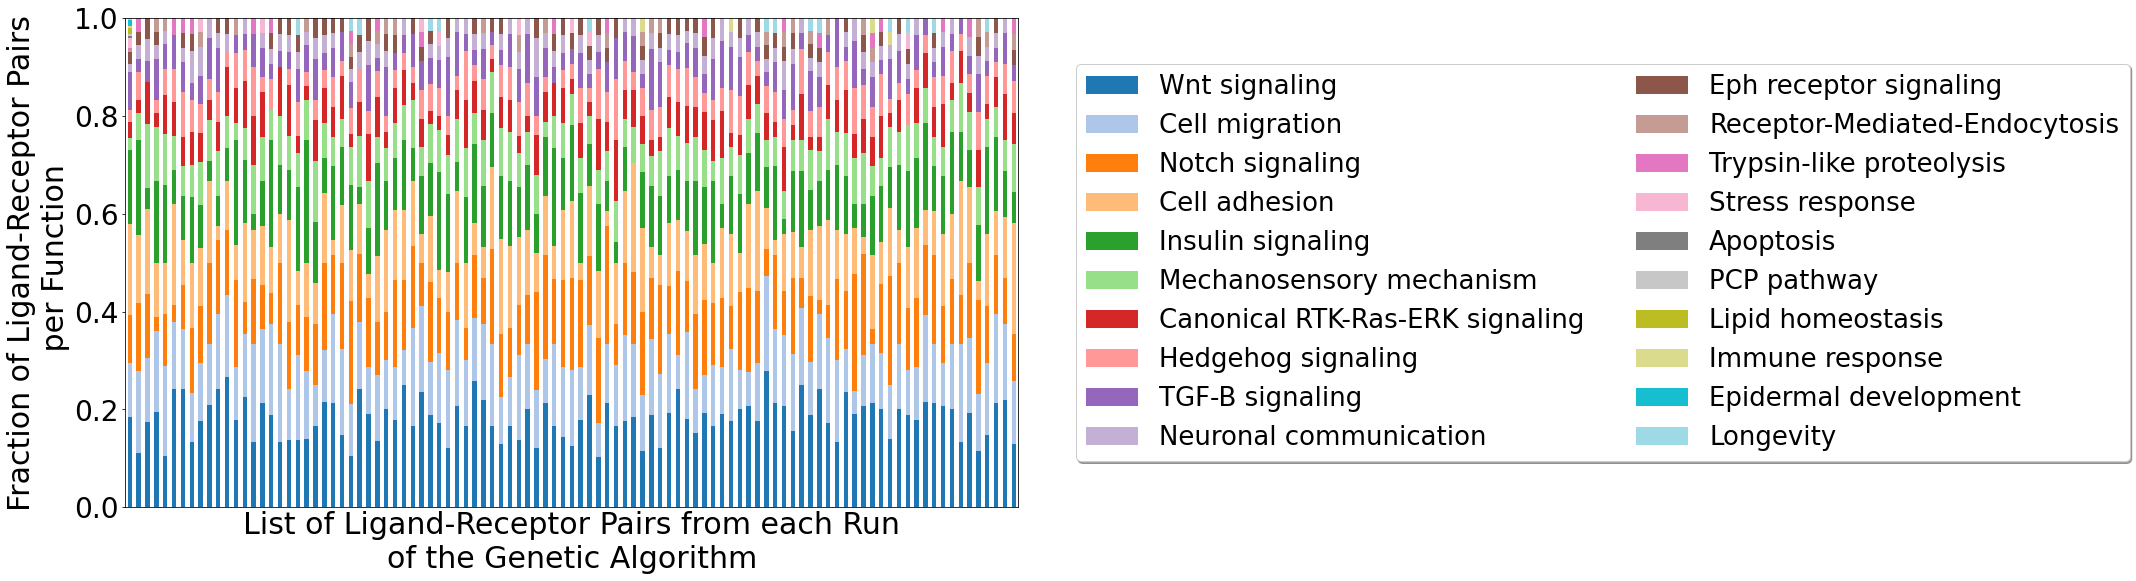

In [67]:
composition = func_frac.loc[sorted_order,:].T#.sort_values(by=list(sorted_order)[:5], ascending=False)
composition = composition.T
composition['Complete'] = symbol_lrs.groupby('LR Function').count()['index'] / len(symbol_lrs)
composition[['Complete'] + list(composition.columns)[:-1]].T.plot(kind='bar', stacked=True, cmap='tab20', figsize=(16, 9))
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
              ncol=2, fancybox=True, shadow=True, fontsize=26)
plt.ylim((0,1))

plt.xlabel('List of Ligand-Receptor Pairs from each Run\nof the Genetic Algorithm', fontsize=30)
plt.ylabel('Fraction of Ligand-Receptor Pairs\n per Function', fontsize=30)

plt.tick_params(axis='y', labelsize=28)
plt.xticks([])

plt.savefig(output_folder + '/Functional-Composition-GA-ICELLNET-Runs.svg',
                dpi=300,
                bbox_inches='tight')

**Presence in all GA runs**

In [68]:
(func_frac.T != 0).all()

index
Apoptosis                          False
Canonical RTK-Ras-ERK signaling    False
Cell adhesion                       True
Cell migration                      True
Eph receptor signaling             False
Epidermal development              False
Hedgehog signaling                 False
Immune response                    False
Insulin signaling                  False
Lipid homeostasis                  False
Longevity                          False
Mechanosensory mechanism            True
Neuronal communication             False
Notch signaling                     True
PCP pathway                        False
Receptor-Mediated-Endocytosis      False
Stress response                    False
TGF-B signaling                    False
Trypsin-like proteolysis           False
Wnt signaling                       True
dtype: bool

**Presence in at least one GA run**

In [69]:
(func_frac.T != 0).any()

index
Apoptosis                          False
Canonical RTK-Ras-ERK signaling     True
Cell adhesion                       True
Cell migration                      True
Eph receptor signaling              True
Epidermal development              False
Hedgehog signaling                  True
Immune response                     True
Insulin signaling                   True
Lipid homeostasis                  False
Longevity                           True
Mechanosensory mechanism            True
Neuronal communication              True
Notch signaling                     True
PCP pathway                        False
Receptor-Mediated-Endocytosis       True
Stress response                     True
TGF-B signaling                     True
Trypsin-like proteolysis            True
Wnt signaling                       True
dtype: bool

**Wilcoxon test to detect functions that change proportions across GA runs**

In [70]:
wilcoxon_functions = pd.DataFrame(columns=['P-val'])
for idx, row in func_frac.iterrows():
    wilcoxon_functions.at[idx, 'Greater P-val'] = scipy.stats.wilcoxon(row.values-composition.loc[idx, 'Complete'],
                                                                       alternative='greater')[1]
    wilcoxon_functions.at[idx, 'Less P-val'] = scipy.stats.wilcoxon(row.values-composition.loc[idx, 'Complete'],
                                                                       alternative='less')[1]

**FDR correction**

In [71]:
from statsmodels.stats.multitest import multipletests

In [72]:
wilcoxon_functions['Greater Q-val'] = multipletests(wilcoxon_functions['Greater P-val'].values.flatten(), alpha=0.01, method='fdr_bh')[1]
wilcoxon_functions['Less Q-val'] = multipletests(wilcoxon_functions['Less P-val'].values.flatten(), alpha=0.01, method='fdr_bh')[1]

**Functions that increased their fraction across the GA-selected lists**

In [73]:
wilcoxon_functions['Greater Q-val'] < 0.01

Apoptosis                          False
Canonical RTK-Ras-ERK signaling     True
Cell adhesion                      False
Cell migration                      True
Eph receptor signaling             False
Epidermal development              False
Hedgehog signaling                  True
Immune response                    False
Insulin signaling                  False
Lipid homeostasis                  False
Longevity                          False
Mechanosensory mechanism            True
Neuronal communication              True
Notch signaling                     True
PCP pathway                        False
Receptor-Mediated-Endocytosis      False
Stress response                    False
TGF-B signaling                    False
Trypsin-like proteolysis           False
Wnt signaling                      False
Name: Greater Q-val, dtype: bool

**Functions that decreased their fraction across the GA-selected lists**

In [74]:
wilcoxon_functions['Less Q-val'] < 0.01

Apoptosis                           True
Canonical RTK-Ras-ERK signaling    False
Cell adhesion                       True
Cell migration                     False
Eph receptor signaling             False
Epidermal development               True
Hedgehog signaling                 False
Immune response                     True
Insulin signaling                   True
Lipid homeostasis                   True
Longevity                           True
Mechanosensory mechanism           False
Neuronal communication             False
Notch signaling                    False
PCP pathway                         True
Receptor-Mediated-Endocytosis      False
Stress response                     True
TGF-B signaling                     True
Trypsin-like proteolysis            True
Wnt signaling                      False
Name: Less Q-val, dtype: bool

**Functions that neither increased or decreased their fraction in the GA-selected lists**

In [75]:
~((wilcoxon_functions['Greater Q-val'] < 0.01) | (wilcoxon_functions['Less Q-val'] < 0.01))

Apoptosis                          False
Canonical RTK-Ras-ERK signaling    False
Cell adhesion                      False
Cell migration                     False
Eph receptor signaling              True
Epidermal development              False
Hedgehog signaling                 False
Immune response                    False
Insulin signaling                  False
Lipid homeostasis                  False
Longevity                          False
Mechanosensory mechanism           False
Neuronal communication             False
Notch signaling                    False
PCP pathway                        False
Receptor-Mediated-Endocytosis       True
Stress response                    False
TGF-B signaling                    False
Trypsin-like proteolysis           False
Wnt signaling                       True
dtype: bool

In [76]:
wilcoxon_functions.loc[sorted_order, ['Greater Q-val', 'Less Q-val']].min(axis=1)

index
Wnt signaling                      6.013570e-01
Cell migration                     1.825332e-08
Notch signaling                    3.038427e-10
Cell adhesion                      9.061083e-17
Insulin signaling                  1.513428e-10
Mechanosensory mechanism           3.787682e-17
Canonical RTK-Ras-ERK signaling    4.984380e-13
Hedgehog signaling                 5.554761e-16
TGF-B signaling                    3.006341e-11
Neuronal communication             1.825332e-08
Eph receptor signaling             2.337827e-02
Receptor-Mediated-Endocytosis      2.807232e-01
Trypsin-like proteolysis           3.024558e-03
Stress response                    3.488015e-21
Apoptosis                          3.809927e-23
PCP pathway                        3.809927e-23
Lipid homeostasis                  3.809927e-23
Immune response                    1.686896e-16
Epidermal development              3.809927e-23
Longevity                          5.294398e-06
dtype: float64

In [77]:
print(*wilcoxon_functions.index, sep='\n')

Apoptosis
Canonical RTK-Ras-ERK signaling
Cell adhesion
Cell migration
Eph receptor signaling
Epidermal development
Hedgehog signaling
Immune response
Insulin signaling
Lipid homeostasis
Longevity
Mechanosensory mechanism
Neuronal communication
Notch signaling
PCP pathway
Receptor-Mediated-Endocytosis
Stress response
TGF-B signaling
Trypsin-like proteolysis
Wnt signaling
